In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import echopype as ep
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from skimage import feature


In [3]:
fname = 'F:GLIDER2018/Echosounder/Echosounder/nc_files/GLIDER_SB_2018_v5-Phase0-D20180626-T053123-0.nc'
ed = ep.open_converted(fname)
ds = ep.calibrate.compute_Sv(ed, waveform_mode='BB', encode_mode='complex')
ds

UnboundLocalError: local variable 'gain' referenced before assignment

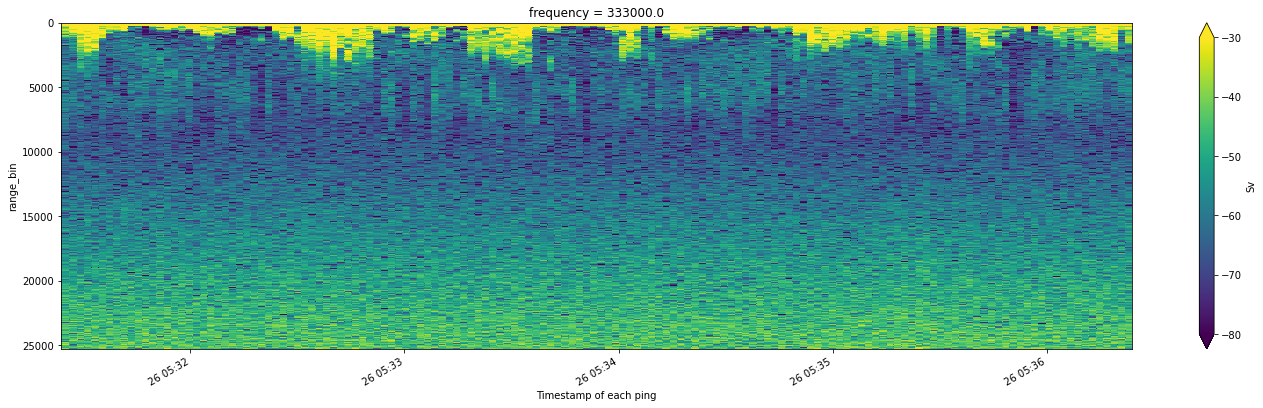

In [140]:
fig = (ds.Sv).plot(x='ping_time', size=6, aspect=4, cmap="viridis", vmin=-80, vmax=-30)
fig.figure.patch.set_facecolor('white')
plt.gca().invert_yaxis()

# remove near-field
When the echosounder emits a ping, it takes some time for the ping to be fully formed and linear. To avoid non-linear effects, we remove the near-field before any processing.

In [141]:
nearfield = 3 #m from transducer face
maxSNR = 50.5 #m signal to noise ratio
ds = ds.where((ds.range>nearfield) & (ds.range<maxSNR),drop=True)
ds = ds.isel(frequency=0) # remove frequency dimension
ds

<xarray.Dataset>
Dimensions:                (ping_time: 148, range_bin: 8011)
Coordinates:
  * ping_time              (ping_time) datetime64[ns] 2018-06-26T05:31:24.965...
    frequency              float64 3.33e+05
  * range_bin              (range_bin) int32 634 635 636 637 ... 8642 8643 8644
Data variables:
    Sv                     (ping_time, range_bin) float64 -28.99 ... -64.36
    range                  (ping_time, range_bin) float64 3.001 3.007 ... 50.5
    temperature            (ping_time, range_bin) float64 8.0 8.0 ... nan nan
    salinity               (ping_time, range_bin) float64 35.0 35.0 ... nan nan
    pressure               (ping_time, range_bin) float64 5.0 5.0 ... nan nan
    sound_speed            (ping_time, range_bin) float64 1.482e+03 ... nan
    sound_absorption       (ping_time, range_bin) float64 0.08015 ... nan
    sa_correction          (ping_time, range_bin) float64 0.0 0.0 ... 0.0 0.0
    gain_correction        (ping_time, range_bin) float64 24.0 24.0 ... 24.0
    equivalent_beam_angle  (ping_time, range_bin) float64 -21.0 -21.0 ... -21.0

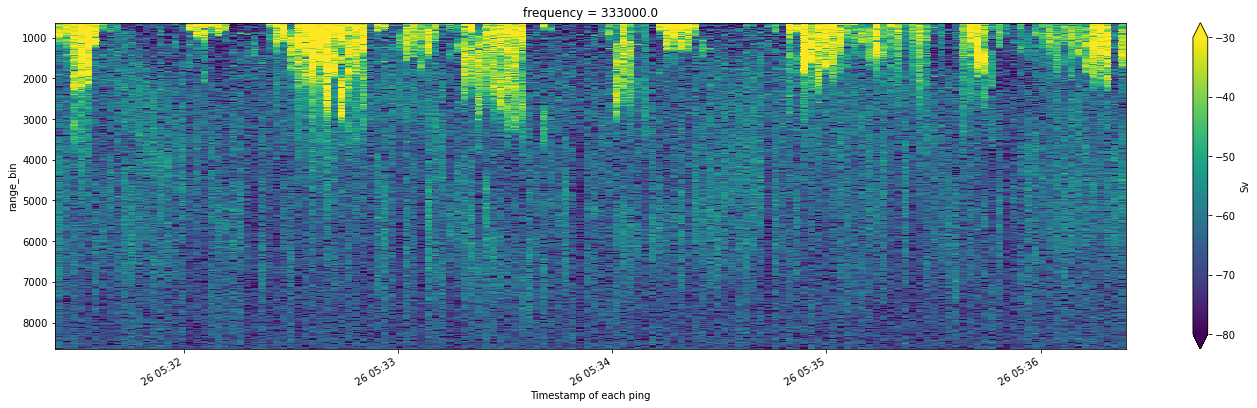

In [142]:
fig = ds.Sv.plot(x='ping_time', size=6, aspect=4, cmap="viridis", vmin=-80, vmax=-30)
plt.gca().invert_yaxis()

# remove the bubbles

remove the bubbles by setting the surface values to min of the signal

In [143]:
ds_s = ds[['Sv']]
ds_s

<xarray.Dataset>
Dimensions:    (ping_time: 148, range_bin: 8011)
Coordinates:
  * ping_time  (ping_time) datetime64[ns] 2018-06-26T05:31:24.965000192 ... 2...
    frequency  float64 3.33e+05
  * range_bin  (range_bin) int32 634 635 636 637 638 ... 8641 8642 8643 8644
Data variables:
    Sv         (ping_time, range_bin) float64 -28.99 -53.0 ... -72.13 -64.36

window depth=80
window time=12
time min init: 2018-06-26T05:31:24.965000192, max: 2018-06-26T05:36:22.912999936
len time: 148
time min smooth: 2018-06-26T05:31:24.965000192, max: 2018-06-26T05:36:22.912999936
len time smooth: 148


C:\Users\mbd\anaconda3\lib\site-packages\xarray\core\variable.py:131: DeprecationWarning: Using a DataArray object to construct a variable is ambiguous, please extract the data using the .data property. This will raise a TypeError in 0.19.0.
  DeprecationWarning,
C:\Users\mbd\anaconda3\lib\site-packages\xarray\core\variable.py:131: DeprecationWarning: Using a DataArray object to construct a variable is ambiguous, please extract the data using the .data property. This will raise a TypeError in 0.19.0.
  DeprecationWarning,


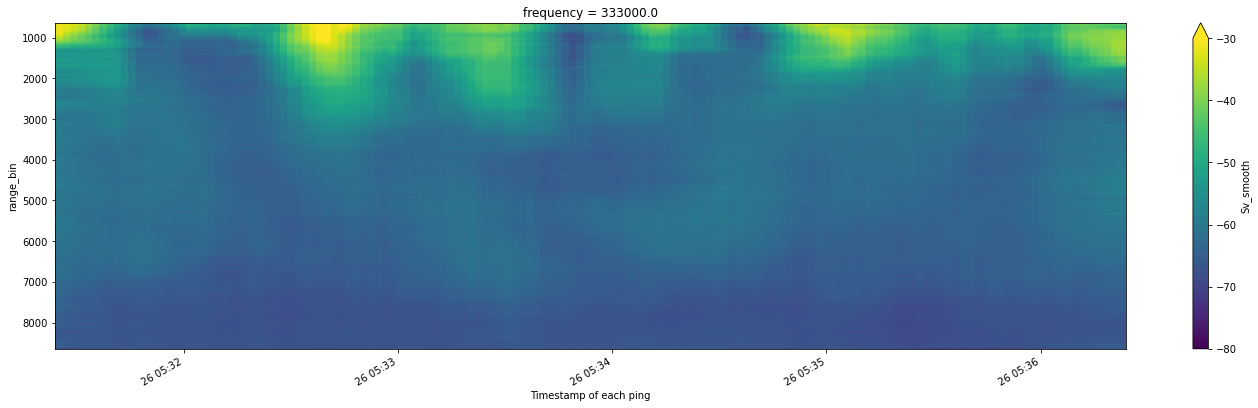

In [144]:
time_smoothing = max(len(ds_s['ping_time'].data)//12, 1)
depth_smoothing = len(ds_s['range_bin'].data)//100
print(f'window depth={depth_smoothing}')
print(f'window time={time_smoothing}')
print(f"time min init: {ds_s['ping_time'].min().data}, max: {ds_s['ping_time'].max().data}")
print(f"len time: {len(ds_s['ping_time'])}")

# smoothing on time axis
Sv_smooth = ds_s['Sv'].pad(ping_time=(time_smoothing, time_smoothing), mode='edge').rolling(ping_time=time_smoothing, center=True).mean()
Sv_smooth = Sv_smooth.isel(ping_time=np.arange(time_smoothing, len(ds_s['ping_time'])+time_smoothing))

# smoothing on depth axis
# Sv_smooth = Sv_smooth.pad(range_bin=(depth_smoothing, depth_smoothing), mode='constant', constant_values=-120).rolling(range_bin=depth_smoothing,
#                                                                                                                                    center=True).mean()
Sv_smooth = Sv_smooth.pad(range_bin=(depth_smoothing, depth_smoothing), mode='edge').rolling(range_bin=depth_smoothing, center=True).mean()
Sv_smooth = Sv_smooth.isel(range_bin=np.arange(depth_smoothing, len(ds_s['range_bin'])+depth_smoothing))
ds_s = ds_s.assign(variables={"Sv_smooth": (('ping_time', 'range_bin'), Sv_smooth.data)})

print(f"time min smooth: {Sv_smooth['ping_time'].min().data}, max: {Sv_smooth['ping_time'].max().data}")
print(f"len time smooth: {len(Sv_smooth['ping_time'])}")

# Simple thresholding using the mean
thresh = ds_s['Sv_smooth'].mean()# threshold_otsu(Sv_smooth.data)
ds_s = ds_s.assign(variables={"Sv_mask": (('ping_time', 'range_bin'), (Sv_smooth>thresh))})

# Edge detection
# Using canny filtering to get the edges of the layers
edges = feature.canny(ds_s['Sv_mask'].data, sigma=11)
ds_s = ds_s.assign(variables={"edges": (('ping_time', 'range_bin'), edges)})

ds_s.Sv_smooth.plot(x='ping_time', size=6, aspect=4, cmap="viridis", vmin=-80, vmax=-30)
plt.gca().invert_yaxis()

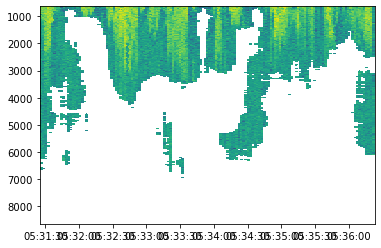

In [145]:
filtered = ds_s['Sv'].where(ds_s['Sv_mask'])
plt.pcolormesh(ds_s.ping_time, ds_s.range_bin,filtered.T);
plt.gca().invert_yaxis()

# Conclusion
Could work but does not provide crisp line. Filtering again, time consuming... Back to kmeans.

Consider adding an "if" statement in k means to repeat with different amount of clusters 
- if cluster[0] mean(sv)>x dB?
    - clusters = 4
    - rerun kmean?